In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), "ppdf-analysis", "beam-analysis"))
import torch
import torch.nn as nn
# from torch import Tensor
import matplotlib.pyplot as plt
import matplotlib
import h5py
import numpy as np
from matplotlib import colors as mpl_colors
from matplotlib.axes import Axes
import time
import kornia.filters as kornia_filters

from geom_2d_plot import (
    plot_polygons_from_vertices_mpl,
    plot_new_ppdf_mpl,
    plot_scanner_from_vertices_2d_mpl,
)
from geom_2d_functions import get_point_fov_hull_2d_batch, get_local_max_1d
from beam_property_torch import get_data_samples_on_arc_2d
# from raytracer_2d import get_cuts_ray_on_edges_2d

In [ ]:
def load_scanner_layouts(filename: str):
    from torch import load as torch_load
    import os

    if not os.path.exists(filename):
        print(f"File {filename} does not exist.")
        raise FileNotFoundError(f"File {filename} does not exist.")
    filename_unique_id = filename.split(".")[0].split("_")[-1]
    scanner_layouts_data = torch_load(filename, weights_only=True)["layouts"]
    return scanner_layouts_data, filename_unique_id


def load_scanner_layout_geometries(layout_idx: int, scanner_layouts_data):
    # Load the scanner geometry
    plates_vertices = scanner_layouts_data[f"position {layout_idx:03d}"][
        "plate segments"
    ].to("cpu")
    detector_units_vertices = scanner_layouts_data[f"position {layout_idx:03d}"][
        "detector units"
    ].to("cpu")
    return plates_vertices, detector_units_vertices


In [3]:
from torch import tensor

scanner_layouts_dir = "../pymatcal/scanner_layouts"
scanner_layouts_filename = "scanner_layouts_77faff53af5863ca146878c7c496c75e.tensor"

scanner_layouts, filename_unique_id = load_scanner_layouts(
    os.path.join(scanner_layouts_dir, scanner_layouts_filename)
)
plates_vertices, detector_units_vertices = load_scanner_layout_geometries(
    0, scanner_layouts
)  # Load the first layout (index 0)

fov_dict = {
    "n pixels": tensor([512, 512]),
    "mm per pixel": tensor([0.25, 0.25]),
    "center coordinates in mm": tensor([0.0, 0.0]),
}
fov_dict["size in mm"] = fov_dict["n pixels"] * fov_dict["mm per pixel"]


ppdfs_dataset_dir = "../../data/scanner_layouts_77faff53af5863ca146878c7c496c75e"
ppdfs_hdf5_filename = "position_000_ppdfs.hdf5"

with h5py.File(
    os.path.join(ppdfs_dataset_dir, ppdfs_hdf5_filename), "r"
) as f:
    # Print the names of all datasets in the file
    # print("Datasets in the file:")
    #  for name in f:
    #      print(name)
    ppdfs = f["ppdfs"][:]
    ppdfs = tensor(ppdfs)

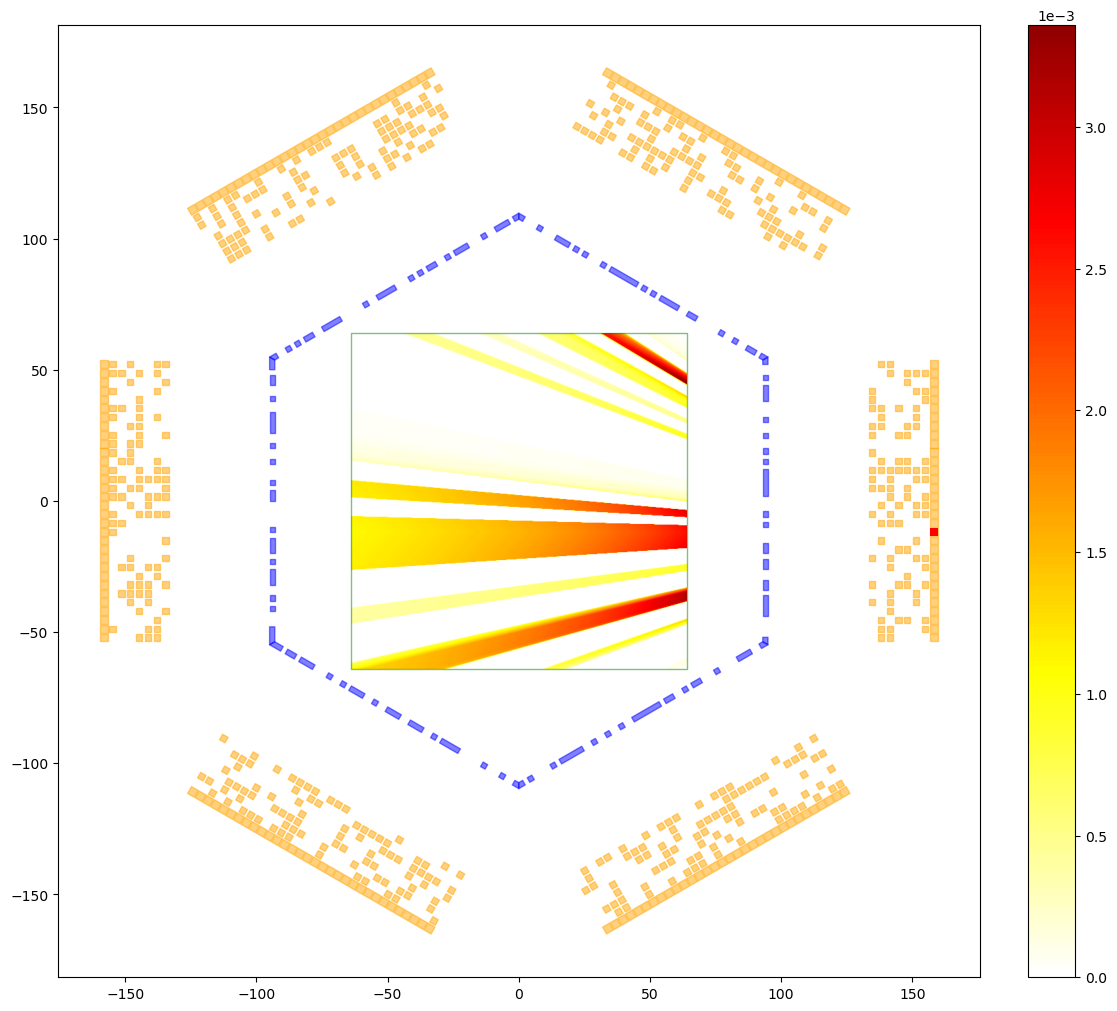

In [4]:
selected_detector_unit_idx = 101

fig, ax = plt.subplots(figsize=(11, 10), layout="constrained")

# print(ppdfs.shape,"512 x 512 =", 512 * 512)
# Plot the ppdfs
plot_new_ppdf_mpl(
    ppdfs[selected_detector_unit_idx].reshape(512, 512),
    ax=ax,
    fov_dict=fov_dict,
)

# Plot the scanner layout
scanner_polygon_collection_dict = plot_scanner_from_vertices_2d_mpl(
    plates_vertices,
    detector_units_vertices,
    ax=ax,
    fov_dict=fov_dict,
)

# plot the selected detector unit
selected_detector_unit_polygon_collection = plot_polygons_from_vertices_mpl(
    detector_units_vertices[selected_detector_unit_idx].unsqueeze(0),
    ax=ax,
    fc="red",
    ec="none",
)

In [5]:
def get_arc_nodes_2d(
    convex_hull: torch.Tensor,
    crystal_center: torch.Tensor,
):
    """
    Get the arc nodes for the spiral sampling.
    The second node controls the curvature of the spiral.
    """

    # find the closest point in the convex hull (excluding the crystal center) to the center of the crystal

    distances = torch.norm(convex_hull - crystal_center, dim=1)
    indices = torch.argsort(distances)
    nodes = convex_hull[indices][1:3]

    rads = torch.atan2(
        nodes[:, 1] - crystal_center[1],
        nodes[:, 0] - crystal_center[0],
    )
    rads = rads + 2 * torch.pi * (rads < 0)
    distances = distances[indices][1:3]
    return torch.stack([distances, rads], dim=1)


def get_sampling_arc_coordinates_2d(nodes, n=100):
    """Get spiral sampling coordinates in 2D."""
    ends = nodes[nodes[:, 1].argsort()]
    angles = torch.linspace(ends[0, 1], ends[1, 1], n)
    radius = torch.linspace(ends[0, 0], ends[1, 0], n)

    x = radius * torch.cos(angles)
    y = radius * torch.sin(angles)
    return torch.stack((x, y), dim=-1), angles


def get_data_samples_on_arc_2d(
    data_batch: torch.Tensor,
    crystal_centers: torch.Tensor,
    crystal_id: int,
    hull_batch: torch.Tensor,
    mask_batch: torch.Tensor,
    n_samples,
    fov_dict: dict,
):
    arc_nodes = get_arc_nodes_2d(
        hull_batch[crystal_id][mask_batch[crystal_id]],
        crystal_centers[crystal_id],
    )
    sampling_points, sampling_rads = get_sampling_arc_coordinates_2d(
        arc_nodes,
        n=n_samples,
    )
    sampling_points = sampling_points + crystal_centers[crystal_id]

    # Prepare the input and grid for sampling
    input_field = (
        data_batch[crystal_id]
        .T.view(1, 1, int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1]))
        .to(torch.float32)
    )
    # The grid contains the coordinates of the points where the input scalar
    # field is sampled. The grid is in the range [-1, 1] for both x and y.

    grid = (
        sampling_points.unsqueeze(0).unsqueeze(0).to(torch.float32)
        / torch.tensor(fov_dict["size in mm"])
        * 2
    )

    #
    samples = nn.functional.grid_sample(
        input_field, grid, mode="bilinear", align_corners=True
    ).squeeze()
    return samples, sampling_rads, sampling_points


def get_data_samples_on_arc_2d_local(
    data_2d: torch.Tensor,
    detector_center: torch.Tensor,
    hull_2d: torch.Tensor,
    n_samples,
    fov_dict: dict,
):
    arc_nodes = get_arc_nodes_2d(
        hull_2d,
        detector_center,
    )
    sampling_points, sampling_rads = get_sampling_arc_coordinates_2d(
        arc_nodes,
        n=n_samples,
    )
    sampling_points = sampling_points + detector_center

    # Prepare the input and grid for sampling
    input_field = data_2d.T.view(
        1, 1, int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
    ).to(torch.float32)
    
    # The grid contains the coordinates of the points where the input scalar
    # field is sampled. The grid is in the range [-1, 1] for both x and y.

    grid = (
        sampling_points.unsqueeze(0).unsqueeze(0).to(torch.float32)
        / torch.tensor(fov_dict["size in mm"])
        * 2
    )

    #
    samples = nn.functional.grid_sample(
        input_field, grid, mode="bilinear", align_corners=True
    ).squeeze()
    return samples, sampling_rads, sampling_points

In [6]:
ppdfs = ppdfs.view(-1, 512, 512).unsqueeze(1)
# Filter the PPDFs with gaussian blur
ppdfs_blured = kornia_filters.gaussian_blur2d(
    ppdfs, (5, 5), (4, 4)
)
detector_units_centers = detector_units_vertices.mean(dim=1)
hull_batch, mask_batch = get_point_fov_hull_2d_batch(detector_units_centers, fov_dict)

In [7]:

# Get the edges data with Laplacian filter from the blurred PPDFs
ppdfs_blured = ppdfs
data_batch = (
    kornia_filters.laplacian(ppdfs_blured, kernel_size=3)
    .clamp(0.0, 1.0)
    .squeeze()
)
# data_batch = 

/tmp/ipykernel_9898/1269130653.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  / torch.tensor(fov_dict["size in mm"])


Text(0.5, 0.98, 'Edge detection with Laplacian filter')

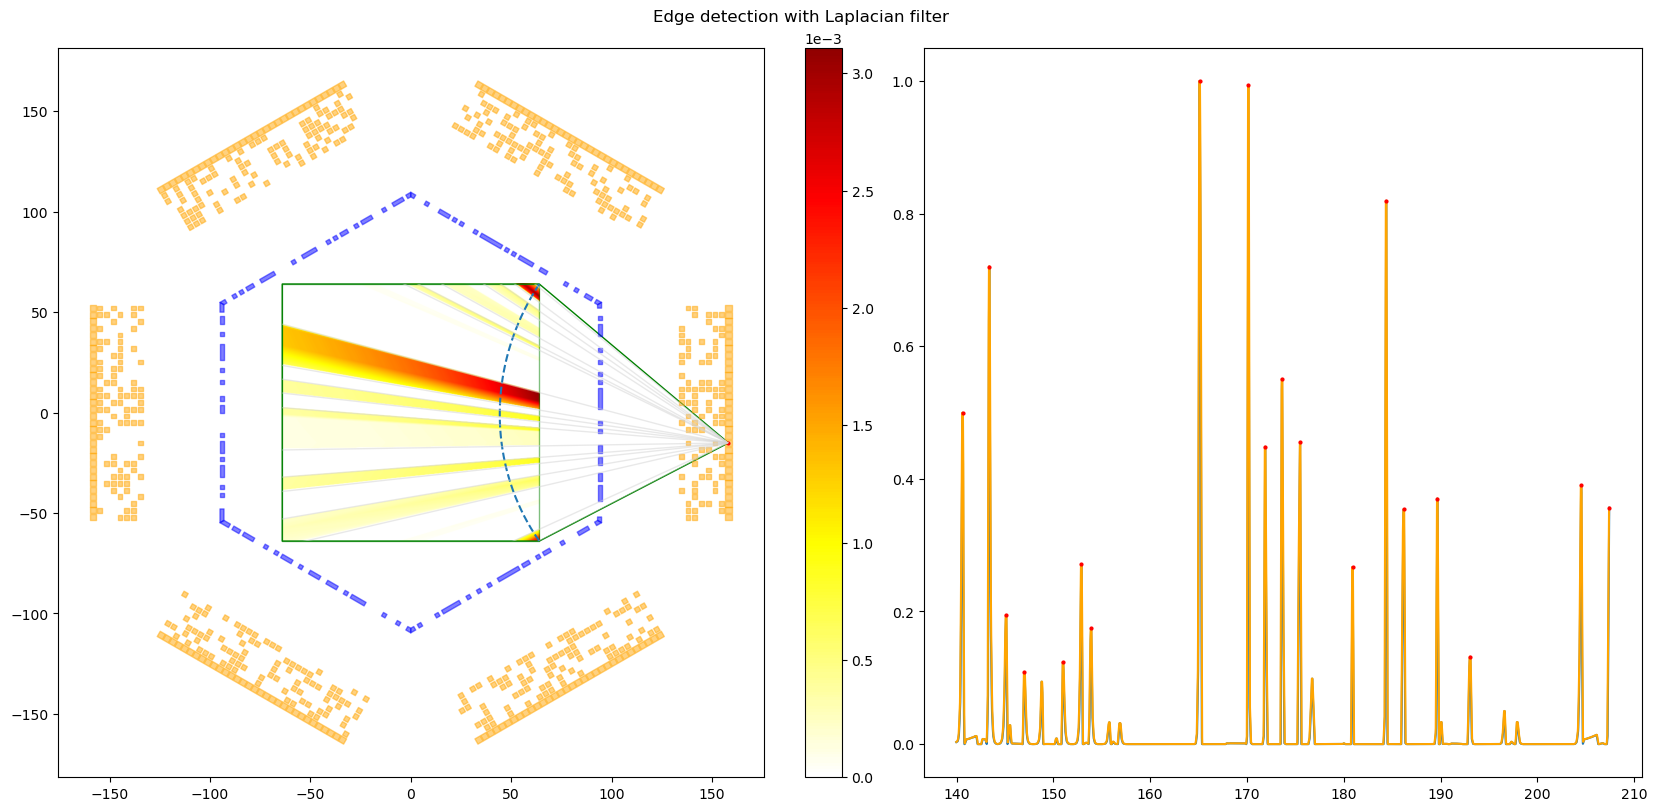

In [8]:


crystal_id = 100
# crystal_id = 332

eps = 1e-6

plt.close("all")
fig, axs = plt.subplots(
    1,
    2,
    figsize=(17, 8),
    layout="constrained",
    gridspec_kw={"width_ratios": [9, 8]},
)
hull_mpl_obj = plot_polygons_from_vertices_mpl(
    hull_batch[crystal_id, mask_batch[crystal_id]].unsqueeze(0),
    axs[0],
    fc="none",
    ec="g",
    # alpha=0.1,
)
scanner_mpl_objs = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, axs[0], fov_dict
)

(
    samples,
    sample_rads,
    sample_xy,
) = get_data_samples_on_arc_2d_local(
    data_batch[crystal_id],
    detector_units_centers[crystal_id],
    hull_batch[crystal_id, mask_batch[crystal_id]],
    n_samples=4096,
    fov_dict=fov_dict,
)

ppdf_imshow_obj = plot_new_ppdf_mpl(ppdfs_blured[crystal_id, 0], axs[0], fov_dict)

axs[0].plot(
    detector_units_centers[crystal_id, 0],
    detector_units_centers[crystal_id, 1],
    "ro",
    markersize=2,
    label="crystal center",
)
axs[0].plot(
    sample_xy[:, 0],
    sample_xy[:, 1],
    "--",
    markersize=2,
    label="sample points",
)

# axs[0].set_xlim(0,50)
# axs[0].set_ylim(0,50)
samples_normalized = samples / samples.max()
axs[1].plot(sample_rads / torch.pi * 180, samples_normalized)

# sample_local_mean = get_local_mean_1d(samples_normalized, kernel_size=3)
sample_local_max = get_local_max_1d(samples_normalized, size=5)

axs[1].plot(
    sample_rads / torch.pi * 180,
    sample_local_max.detach().numpy() - eps,
    color="orange",
)
eps = 1e-6


# Find the edges and ignore dull edges
edge_indices = torch.argwhere(
    torch.logical_and(
        samples_normalized > sample_local_max - eps, sample_local_max > 0.1
    )
)
# edge_indices = edge_indices[edge_indices > 2]
# edge_indices = edge_indices[edge_indices < samples.shape[0] - 2]
# print(edge_indices)

axs[1].plot(
    sample_rads[edge_indices] / torch.pi * 180,
    samples_normalized[edge_indices],
    "ro",
    markersize=2,
    label="local max",
)
for edge_index in edge_indices:
    axline = axs[0].axline(
        xy1=(
            sample_xy[edge_index, 0].item(),
            sample_xy[edge_index, 1].item(),
        ),
        xy2=(
            detector_units_centers[crystal_id, 0].item(),
            detector_units_centers[crystal_id, 1].item(),
        ),
        ls="-",
        color="lightgray",
        lw=1,
        alpha=0.5,
    )
    axline.set_clip_path(
        hull_mpl_obj.get_paths()[0], transform=axline.axes.transData
    )
fig.suptitle("Edge detection with Laplacian filter")
# fig.savefig(
#     "edge_detection_laplacian_filter_crystal_id_{}.png".format(crystal_id),
#     dpi=300,
# )

### Calculate ppdf lineprofile value from edge to edge

In [ ]:
def samples_on_arc_2d_local(
    ppdf_data_2d: torch.Tensor,
    edge_data_2d: torch.Tensor,
    detector_center: torch.Tensor,
    hull_2d: torch.Tensor,
    fov_dict: dict,
    n_samples: int = 1024,
):
    arc_nodes = get_arc_nodes_2d(
        hull_2d,
        detector_center,
    )
    # Get the sampling points and angles
    sampling_points, sampling_rads = get_sampling_arc_coordinates_2d(
        arc_nodes,
        n=n_samples,
    )
    sampling_points = sampling_points + detector_center

    # Prepare the input and grid for sampling
    # 2D edge field
    edge_field = edge_data_2d.T.view(
        1, 1, int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
    ).to(torch.float32)
    # 2D PPDF field
    ppdf_field = ppdf_data_2d.T.view(
        1, 1, int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
    ).to(torch.float32)

    # The grid contains the coordinates of the points where the input scalar
    # field is sampled. The grid is in the range [-1, 1] for both x and y.

    grid = (
        sampling_points.unsqueeze(0).unsqueeze(0).to(torch.float32)
        / fov_dict["size in mm"]
        * 2
    )

    #
    sampled_edge = nn.functional.grid_sample(
        edge_field, grid, mode="bilinear", align_corners=True
    ).squeeze()
    sampled_ppdf = nn.functional.grid_sample(
        ppdf_field, grid, mode="bilinear", align_corners=True
    ).squeeze()
    return sampled_ppdf, sampled_edge, sampling_rads, sampling_points

TypeError: samples_on_arc_2d_local() got an unexpected keyword argument 'kwargs'

#### Plot the sampled ppdf with sampled edge field

torch.Size([4096])


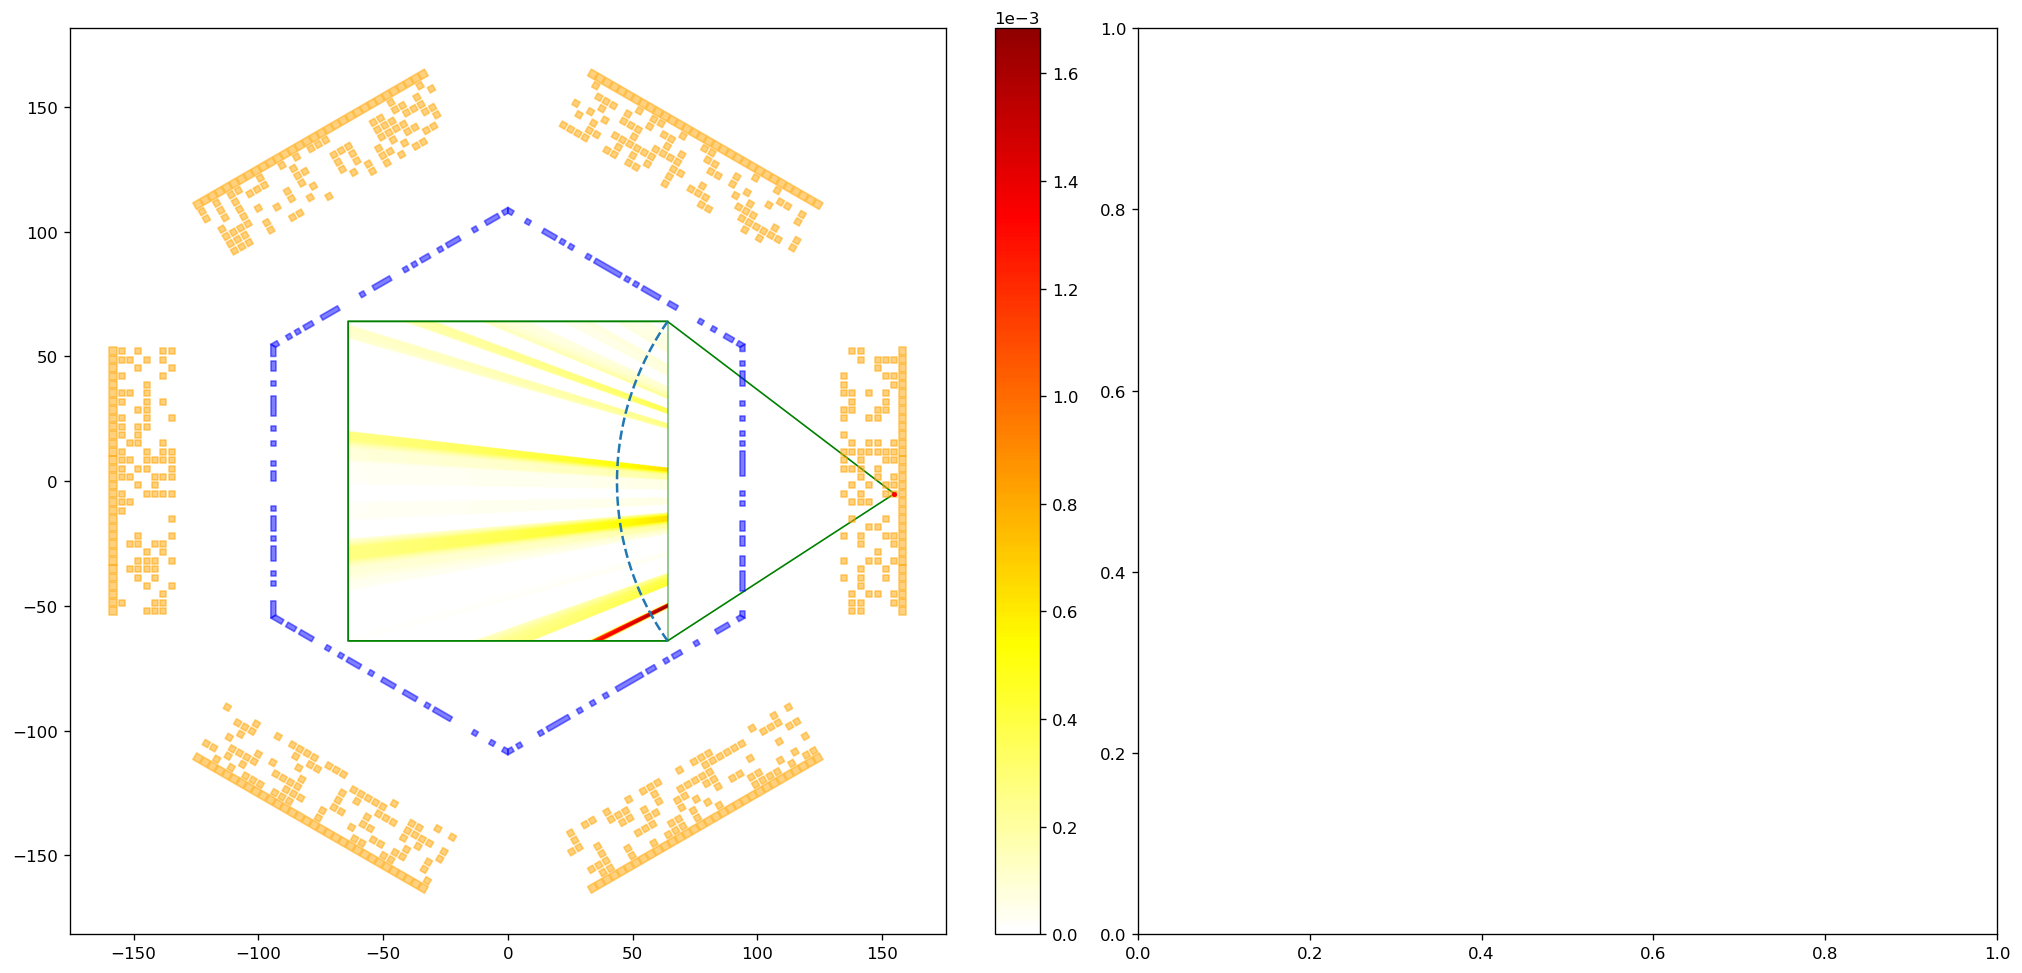

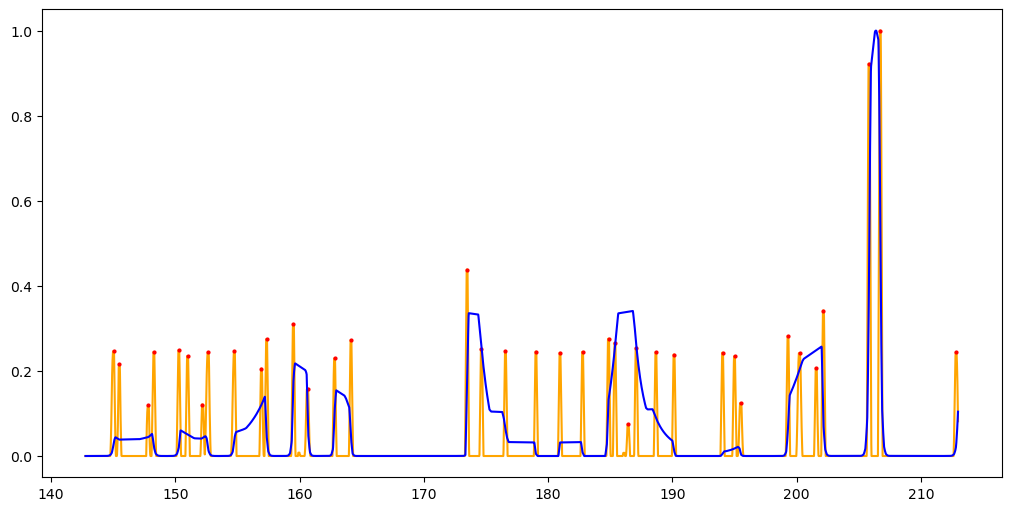

In [12]:
(
    sampled_ppdf,
    sampled_edge,
    sampling_rads,
    sample_xy,
) = samples_on_arc_2d_local(
    ppdfs[crystal_id,0],
    data_2d,
    detector_units_centers[crystal_id],
    hull_batch[crystal_id, mask_batch[crystal_id]],
    fov_dict=fov_dict,
    n_samples=4096,
)
sampled_edge_normalized = sampled_edge / sampled_edge.max()
sampled_ppdf_normalized = sampled_ppdf / sampled_ppdf.max()
sampled_edge_local_max = get_local_max_1d(sampled_edge_normalized, size=5)
# Find the edges and ignore dull edges
edge_indices = torch.argwhere(
    torch.logical_and(
        sampled_edge_normalized > sampled_edge_local_max - eps, sampled_edge_local_max > 0.05
    )
)

%matplotlib inline
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 5),
    layout="constrained",
)


ax.plot(
    sampling_rads / torch.pi * 180,
    sampled_edge_local_max.detach().numpy() - eps,
    color="orange",
)



ax.plot(
    sampling_rads[edge_indices] / torch.pi * 180,
    sampled_edge_normalized[edge_indices],
    "ro",
    markersize=2,
    label="local max",
)

ax.plot(
    sampling_rads / torch.pi * 180,
    sampled_ppdf_normalized.detach().numpy(),
    color="blue",
)
print(sampled_ppdf_normalized.shape)

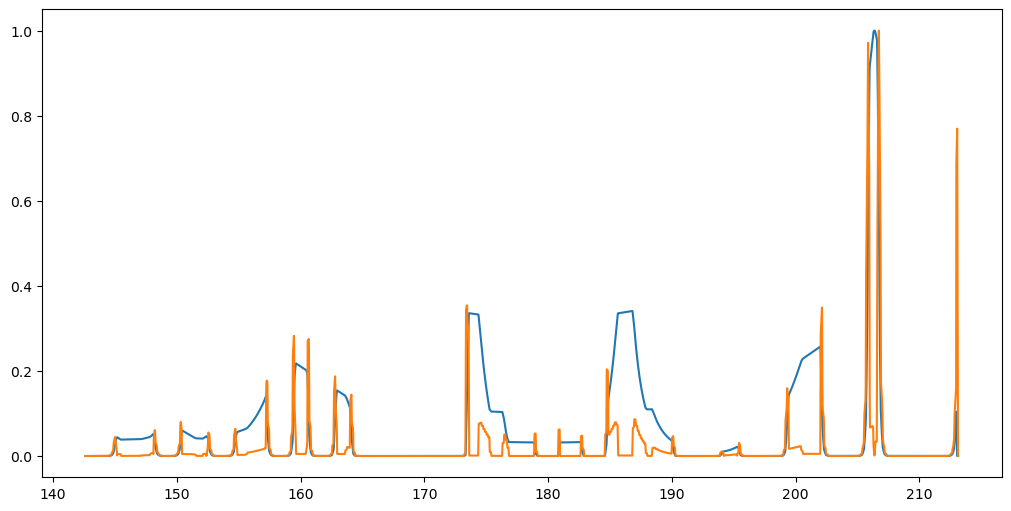

In [13]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 5),
    layout="constrained",
)

# Pad both sides of the sampled data with n zeros
n = 2
sampled_ppdf_normalized_padded = torch.cat(
    [
        torch.zeros(n),
        sampled_ppdf_normalized,
        torch.zeros(n),
    ]
)
sampling_rad_step = sample_rads[1] - sample_rads[0]
sampling_rads_padded = torch.cat(
    [
        -torch.arange(1, n + 1).flip(0) * sampling_rad_step + sampling_rads[0],
        sampling_rads,
        torch.arange(1, n + 1) * sampling_rad_step + sampling_rads[-1],
    ]
)
ax.plot(
    sampling_rads_padded / torch.pi * 180,
    sampled_ppdf_normalized_padded.detach().numpy(),
    color="C0",
)
# calculate the gradient
gradient_amplitude = torch.gradient(sampled_ppdf_normalized_padded,dim=0)[0].abs()
gradient_amplitude_normalized = gradient_amplitude / gradient_amplitude.max()
ax.plot(
    sampling_rads_padded / torch.pi * 180,
    gradient_amplitude_normalized.numpy(),
    color="C1",
)
# print(gradient.shape)
# print(sampling_rads_padded.shape)

torch.Size([32])


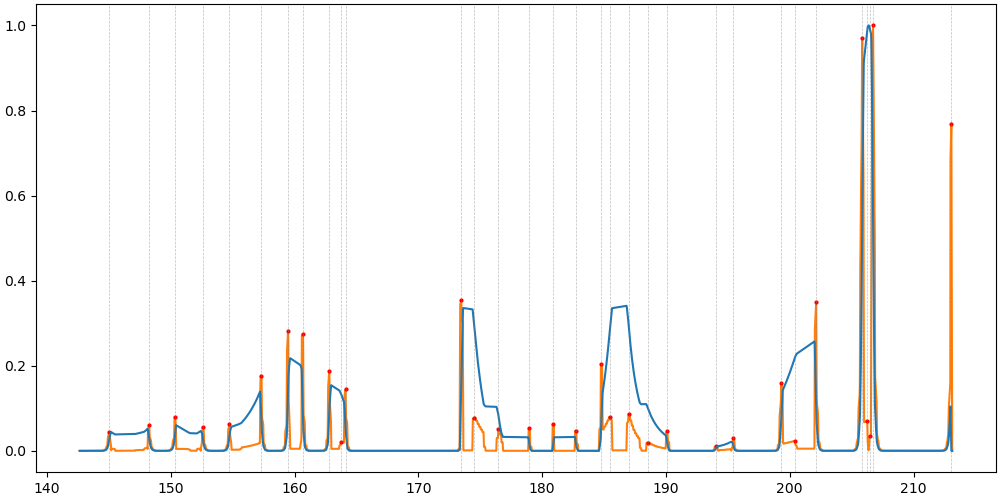

In [14]:
%matplotlib widget
fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 5),
    layout="constrained",
)
eps = 1e-8
gradient_local_max = get_local_max_1d(gradient_amplitude_normalized, size=9)
# gradient_local_max = get_local_max_1d(gradient_amplitude_normalized, size=3)
peak_indices = torch.argwhere(
    torch.logical_and(
        gradient_local_max> 0.01,
        gradient_amplitude_normalized >= gradient_local_max - eps,
    )
).squeeze()
print(peak_indices.shape)
# ax.plot(
#     sampling_rads_padded / torch.pi * 180,
#     gradient_local_max.numpy(),
#     color="C1",
# )
ax.plot(
    sampling_rads_padded / torch.pi * 180,
    gradient_amplitude_normalized.cpu(),
    color="C1",
)
ax.plot(
    sampling_rads_padded[peak_indices] / torch.pi * 180,
    gradient_amplitude_normalized[peak_indices],
    "ro",
    markersize=2,
    label="local max",
)
ax.plot(
    sampling_rads_padded / torch.pi * 180,
    sampled_ppdf_normalized_padded.detach().numpy(),
    color="C0",
)
for peak_rad in sampling_rads_padded[peak_indices] / torch.pi * 180:
    ax.axvline(
        x=peak_rad,
        color="gray",
        linestyle="--",
        linewidth=0.5,
        alpha=0.5,
    )

#### Normalize and threshold the PPDF, perform the arc profiling

In [15]:
normalized_ppdf = ppdfs[crystal_id, 0] / ppdfs[crystal_id, 0].max()
normalized_ppdf_canny = kornia_filters.canny(normalized_ppdf.unsqueeze(0).unsqueeze(0).float(), kernel_size=3)[0].clamp(0.0, 1.0).squeeze()


(
    sampled_ppdf,
    sampled_edge,
    sampling_rads,
    sample_xy,
) = samples_on_arc_2d_local(
    normalized_ppdf,
    normalized_ppdf_canny,
    detector_units_centers[crystal_id],
    hull_batch[crystal_id, mask_batch[crystal_id]],
    fov_dict=fov_dict,
    n_samples=4096,
)
sampled_edge_normalized = sampled_edge / sampled_edge.max()
sampled_ppdf_normalized = sampled_ppdf / sampled_ppdf.max()

In [16]:
crystal_id = 515
normalized_ppdf = ppdfs[crystal_id, 0] / ppdfs[crystal_id, 0].max()
normalized_ppdf_canny = kornia_filters.canny(normalized_ppdf.unsqueeze(0).unsqueeze(0).float(), kernel_size=3)[0].clamp(0.0, 1.0).squeeze()


(
    sampled_ppdf,
    sampled_edge,
    sampling_rads,
    sample_xy,
) = samples_on_arc_2d_local(
    normalized_ppdf,
    normalized_ppdf_canny,
    detector_units_centers[crystal_id],
    hull_batch[crystal_id, mask_batch[crystal_id]],
    fov_dict=fov_dict,
    n_samples=4096,
)
sampled_edge_normalized = sampled_edge / sampled_edge.max()
sampled_ppdf_normalized = sampled_ppdf / sampled_ppdf.max()
# threshold the ppdf arc profile
thresholded_ppdf = torch.zeros_like(sampled_ppdf_normalized)
thresholded_ppdf[sampled_ppdf_normalized > 0.01] = 1
thresholded_ppdf = torch.nn.functional.conv1d(
    thresholded_ppdf.unsqueeze(0).unsqueeze(0),
    torch.ones(1, 1, 3).to(thresholded_ppdf.device),padding="same").squeeze()/3
print(thresholded_ppdf.shape)


torch.Size([4096])


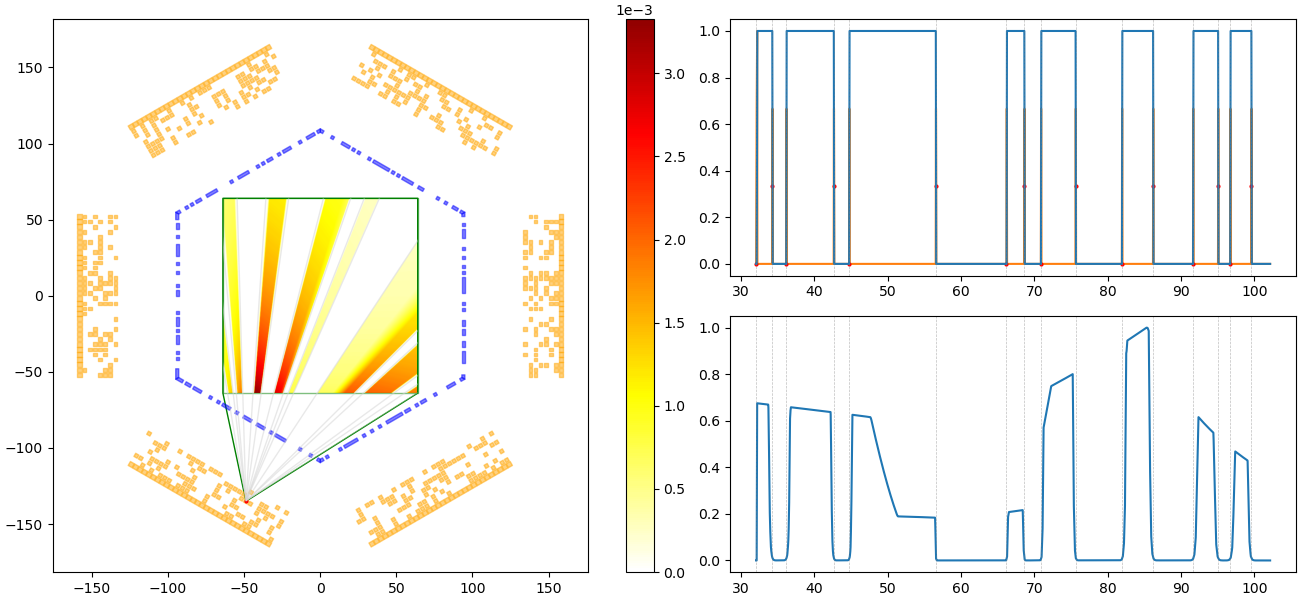

In [17]:
# Pad both sides of the sampled data with n zeros
n = 2
thresholded_ppdf_padded = torch.cat(
    [
        torch.zeros(n),
        thresholded_ppdf,
        torch.zeros(n),
    ]
)
sampled_ppdf_normalized_padded = torch.cat(
    [
        torch.zeros(n),
        sampled_ppdf_normalized,
        torch.zeros(n),
    ]
)

sampling_rad_step = sample_rads[1] - sample_rads[0]
sampling_rads_padded = torch.cat(
    [
        -torch.arange(1, n + 1).flip(0) * sampling_rad_step + sampling_rads[0],
        sampling_rads,
        torch.arange(1, n + 1) * sampling_rad_step + sampling_rads[-1],
    ]
)
# calculate the gradient
gradient_amplitude_padded = torch.gradient(thresholded_ppdf_padded ,dim=0)[0].abs()
gradient_amplitude_padded_normalized = gradient_amplitude_padded / gradient_amplitude_padded.max()
eps = 1e-8
gradient_local_max = get_local_max_1d(gradient_amplitude_padded_normalized, size=9)
# gradient_local_max = get_local_max_1d(gradient_amplitude_normalized, size=3)
peak_indices = torch.argwhere(
    torch.logical_and(
        gradient_local_max> 0.01,
        gradient_amplitude_padded_normalized >= gradient_local_max - eps,
    )
).squeeze()
peak_indices = peak_indices - 2
peak_indices = peak_indices[peak_indices < 4096]

%matplotlib widget
try:
    plt.close("all")
except:
    pass
fig = plt.figure(figsize=(13, 6), layout="constrained")
gs0=fig.add_gridspec(2, 2)
axs = [
    fig.add_subplot(gs0[:, 0]),
    fig.add_subplot(gs0[0, 1]),
    fig.add_subplot(gs0[1, 1]),
]

axs[1].plot(
    sampling_rads_padded / torch.pi * 180,
    gradient_amplitude_padded_normalized.cpu(),
    color="C1",
)
axs[1].plot(
    sampling_rads_padded[peak_indices] / torch.pi * 180,
    gradient_amplitude_padded_normalized[peak_indices],
    "ro",
    markersize=2,
    label="local max",
)
axs[1].plot(
    sampling_rads_padded / torch.pi * 180,
    thresholded_ppdf_padded.numpy(),
    color="C0",
)
axs[2].plot(
    sampling_rads_padded / torch.pi * 180,
    sampled_ppdf_normalized_padded.numpy(),
    color="C0",
)
for peak_rad in sampling_rads_padded[peak_indices] / torch.pi * 180:
    axs[1].axvline(
        x=peak_rad,
        color="gray",
        linestyle="--",
        linewidth=0.5,
        alpha=0.5,
    )
    axs[2].axvline(
        x=peak_rad,
        color="gray",
        linestyle="--",
        linewidth=0.5,
        alpha=0.5,
    )

hull_mpl_obj = plot_polygons_from_vertices_mpl(
    hull_batch[crystal_id, mask_batch[crystal_id]].unsqueeze(0),
    axs[0],
    fc="none",
    ec="g",
    # alpha=0.1,
)
scanner_mpl_objs = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, axs[0], fov_dict
)

ppdf_imshow_obj = plot_new_ppdf_mpl(ppdfs[crystal_id], axs[0], fov_dict)
axs[0].plot(
    detector_units_centers[crystal_id, 0],
    detector_units_centers[crystal_id, 1],
    "ro",
    markersize=2,
    label="detector unit center",
)
for peak_index in peak_indices:
    axline = axs[0].axline(
        xy1=(
            sample_xy[peak_index, 0].item(),
            sample_xy[peak_index, 1].item(),
        ),
        xy2=(
            detector_units_centers[crystal_id, 0].item(),
            detector_units_centers[crystal_id, 1].item(),
        ),
        ls="-",
        color="lightgray",
        lw=1,
        alpha=0.5,
    )
    axline.set_clip_path(
        hull_mpl_obj.get_paths()[0], transform=axline.axes.transData
    )

In [18]:
# Calculate the angles of every pixel to the center of the detector unit
pixel_indices = torch.stack(
    torch.meshgrid(
        torch.arange(0, int(fov_dict["n pixels"][0])),
        torch.arange(0, int(fov_dict["n pixels"][1])),
        indexing="ij",
    ),
    dim=2,
).view(-1, 2)
pixel_coordinates = (
    pixel_indices.float() * fov_dict["mm per pixel"]
    - fov_dict["size in mm"] * 0.5
    + fov_dict["center coordinates in mm"]
)

In [19]:
crystal_id = 515
detector_unit_center = detector_units_centers[crystal_id]
pixel_angles = torch.atan2(
    pixel_coordinates[:, 1] - detector_unit_center[1],
    pixel_coordinates[:, 0] - detector_unit_center[0],
)
# fig, ax = plt.subplots(
#     1,
#     1,
#     figsize=(10, 10),
#     layout="constrained",
# )
# ax.set_aspect("equal")
# ax.plot(pixel_coordinates[:, 0], pixel_coordinates[:, 1], "ro", markersize=2)
# ax.plot(
#     detector_unit_center[0],
#     detector_unit_center[1],
#     "bo",
#     markersize=2,
#     label="detector unit center",
# )
pixel_angles = pixel_angles + 2 * torch.pi * (pixel_angles < 0)
print(pixel_angles.min(), pixel_angles.max())
rads_edges = sampling_rads_padded[peak_indices].sort().values
print(rads_edges)

tensor(0.5628) tensor(1.7805)
tensor([0.5594, 0.5978, 0.6309, 0.7443, 0.7806, 0.9871, 1.1552, 1.1978, 1.2371,
        1.3198, 1.4299, 1.5043, 1.5993, 1.6591, 1.6877, 1.7383])


In [20]:
beams_weighted_centers = torch.empty((0, 2), dtype=torch.float32)
beams_masks = torch.empty((0, int(fov_dict["n pixels"].prod())), dtype=bool)
beams_rads_edges = torch.empty((0, 2), dtype=torch.float32)
print(rads_edges.shape)
for i in range(rads_edges.shape[0] - 1):
    in_range_mask = torch.logical_and(
        pixel_angles >= rads_edges[i],
        pixel_angles <= rads_edges[i + 1],
    )

    # print(in_range_mask.shape)
    normalized_ppdf_mean = normalized_ppdf.view(-1)[in_range_mask].mean()
    # Discard the range with mean < 0.01
    if normalized_ppdf_mean < 0.01:
        continue

    weighted_center = (
        normalized_ppdf.view(-1)[in_range_mask].view(-1, 1).expand(-1, 2)
        * pixel_coordinates[in_range_mask]
    ).sum(dim=0) / (normalized_ppdf.view(-1)[in_range_mask].sum() + 1e-8)

    beams_weighted_centers = torch.cat(
        [
            beams_weighted_centers,
            weighted_center.unsqueeze(0),
        ],
        dim=0,
    )
    beams_masks = torch.cat(
        [
            beams_masks,
            in_range_mask.unsqueeze(0),
        ],
        dim=0,
    )
    beams_rads_edges = torch.cat(
        [
            beams_rads_edges,
            rads_edges[i : i + 2].unsqueeze(0),
        ],
        dim=0,
    )
    print(
        f"Angle range: {float(rads_edges[i].item()/torch.pi*180):03.2f} - {rads_edges[i + 1].item()/torch.pi*180:03.2f} degrees",
        f"PPDF mean: {normalized_ppdf_mean.item():.4f}",
        f"weighted center: {weighted_center}",
        f"number of pixels: {in_range_mask.sum().item()}",
    )

torch.Size([16])
Angle range: 32.05 - 34.25 degrees PPDF mean: 0.3985 weighted center: tensor([ 61.3903, -62.4780]) number of pixels: 402
Angle range: 36.15 - 42.64 degrees PPDF mean: 0.4693 weighted center: tensor([ 50.0982, -52.4931]) number of pixels: 7974
Angle range: 44.72 - 56.56 degrees PPDF mean: 0.2194 weighted center: tensor([ 37.6729, -32.3958]) number of pixels: 39196
Angle range: 66.19 - 68.63 degrees PPDF mean: 0.1076 weighted center: tensor([ 7.1370, -0.1112]) number of pixels: 13797
Angle range: 70.88 - 75.62 degrees PPDF mean: 0.3713 weighted center: tensor([-8.4984, -0.1223]) number of pixels: 24956
Angle range: 81.93 - 86.19 degrees PPDF mean: 0.4085 weighted center: tensor([-34.9286,  -0.1234]) number of pixels: 20795
Angle range: 91.63 - 95.06 degrees PPDF mean: 0.2140 weighted center: tensor([-56.7009,  -0.3749]) number of pixels: 16091
Angle range: 96.70 - 99.59 degrees PPDF mean: 0.2155 weighted center: tensor([-61.5101, -45.0473]) number of pixels: 2763


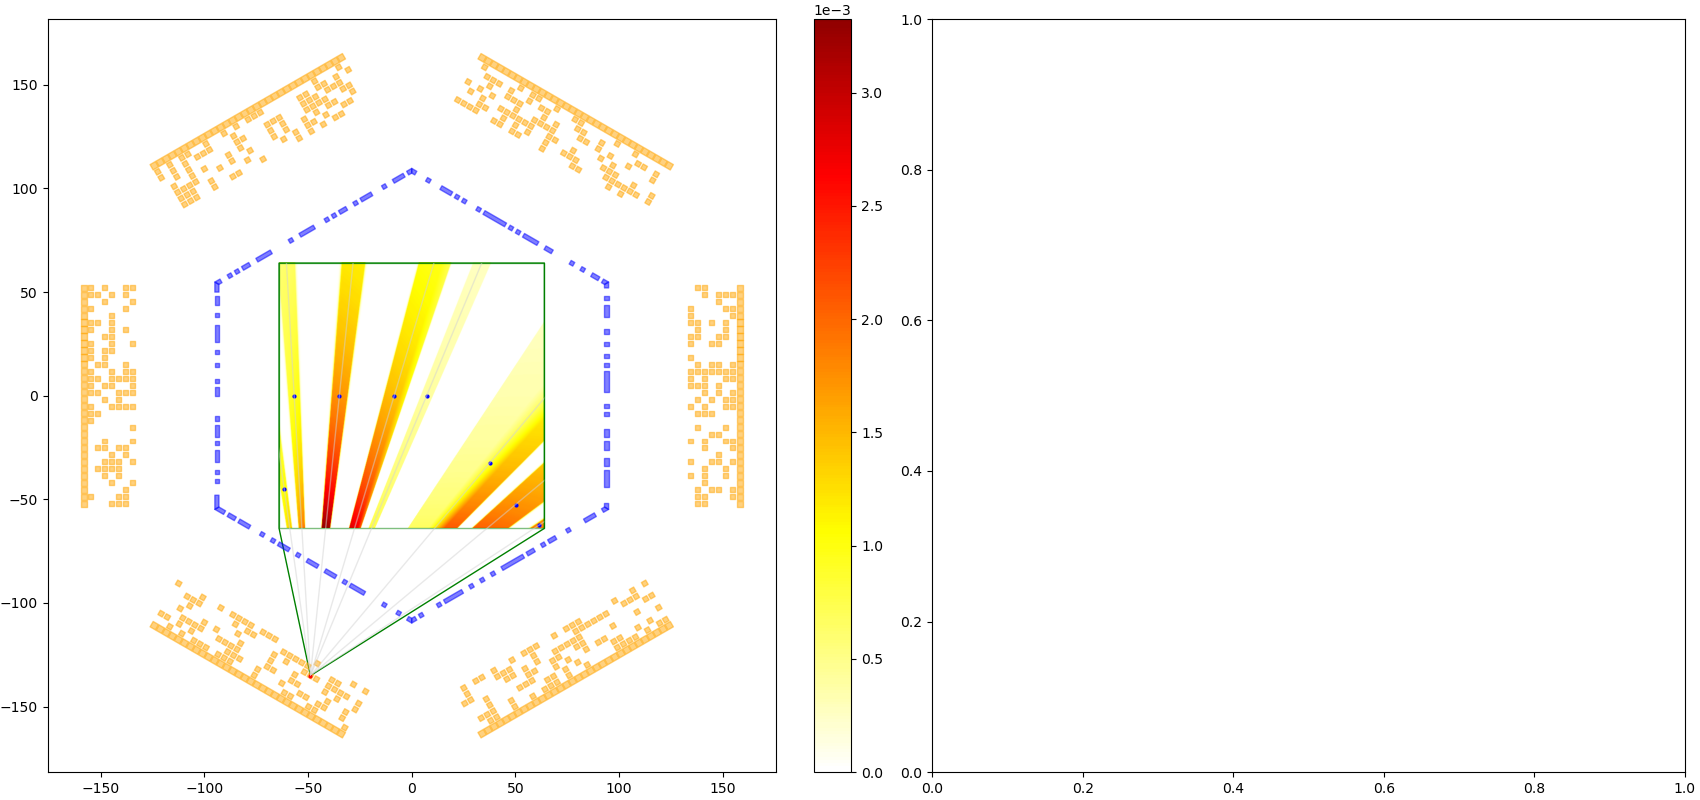

In [21]:
%matplotlib widget
try:
    plt.close("all")
except:
    pass
# fig = plt.figure(figsize=(13, 6), layout="constrained")
# gs0=fig.add_gridspec(2, 2)
# axs = [
#     fig.add_subplot(gs0[:, 0]),
#     fig.add_subplot(gs0[0, 1]),
#     fig.add_subplot(gs0[1, 1]),
# ]

fig, axs = plt.subplots(
    1,2,layout="constrained",figsize=(17, 8))
axs[0].set_aspect("equal")

hull_mpl_obj = plot_polygons_from_vertices_mpl(
    hull_batch[crystal_id, mask_batch[crystal_id]].unsqueeze(0),
    axs[0],
    fc="none",
    ec="g",
    # alpha=0.1,
)
scanner_mpl_objs = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, axs[0], fov_dict
)

ppdf_imshow_obj = plot_new_ppdf_mpl(ppdfs[crystal_id], axs[0], fov_dict)
axs[0].plot(
    detector_units_centers[crystal_id, 0],
    detector_units_centers[crystal_id, 1],
    "ro",
    markersize=2,
    label="detector unit center",
)
axs[0].plot(
    beams_weighted_centers[:, 0],
    beams_weighted_centers[:, 1],
    "bo",
    markersize=2,
    label="beam weighted center",
)


for weighted_center in beams_weighted_centers:
    axline = axs[0].axline(
        xy1=(
            weighted_center[0].item(),
            weighted_center[1].item(),
        ),
        xy2=(
            detector_units_centers[crystal_id, 0].item(),
            detector_units_centers[crystal_id, 1].item(),
        ),
        ls="-",
        color="lightgray",
        lw=1,
        alpha=0.5,
    )
    axline.set_clip_path(
        hull_mpl_obj.get_paths()[0], transform=axline.axes.transData
    )

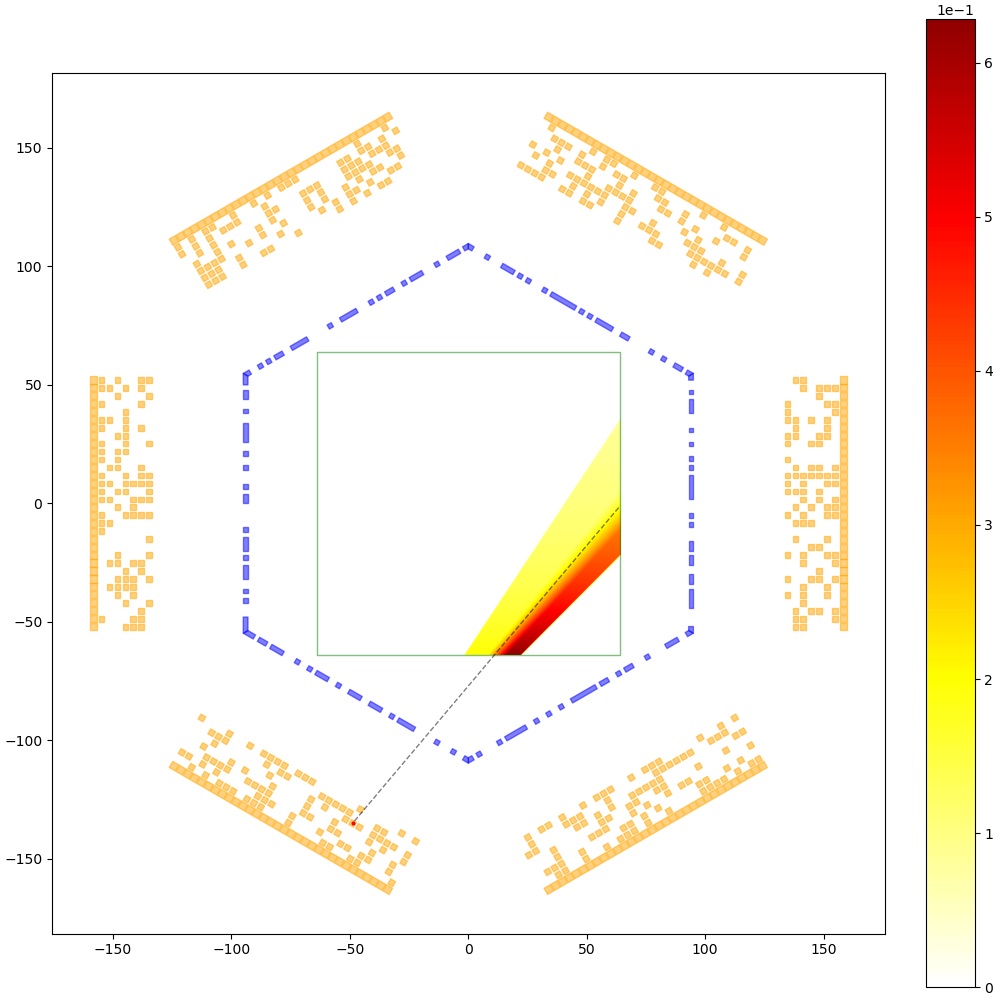

In [22]:
beam_id= 2
template = normalized_ppdf.clone()
template.view(-1)[~beams_masks[beam_id]] = 0

# template.view(-1)[beam_masks[7]] = 1
# template = normalized_ppdf
# template.view(-1)[~beam_masks[0]] = 0
fig, ax = plt.subplots(
    figsize=(10, 10),
    layout="constrained",
)


scanner_mpl_objs = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, ax, fov_dict
)
beam_imshow_obj = plot_new_ppdf_mpl(
    template.view(512, 512),
    ax=ax,
    fov_dict=fov_dict,
)
beam_axis_line = ax.axline(
    xy1=(
        beams_weighted_centers[beam_id, 0].item(),
        beams_weighted_centers[beam_id, 1].item(),
    ),
    xy2=(
        detector_units_centers[crystal_id, 0].item(),
        detector_units_centers[crystal_id, 1].item(),
    ),
    ls="--",
    color="k",
    lw=1,
    alpha=0.5,
)



beam_axis_line.set_clip_path(
    hull_mpl_obj.get_paths()[0], transform=beam_axis_line.axes.transData
)
ax.plot(
    detector_units_centers[crystal_id, 0],
    detector_units_centers[crystal_id, 1],
    "ro",
    markersize=2,
    label="detector unit center",
)
ax.set_aspect("equal")
ax.autoscale()

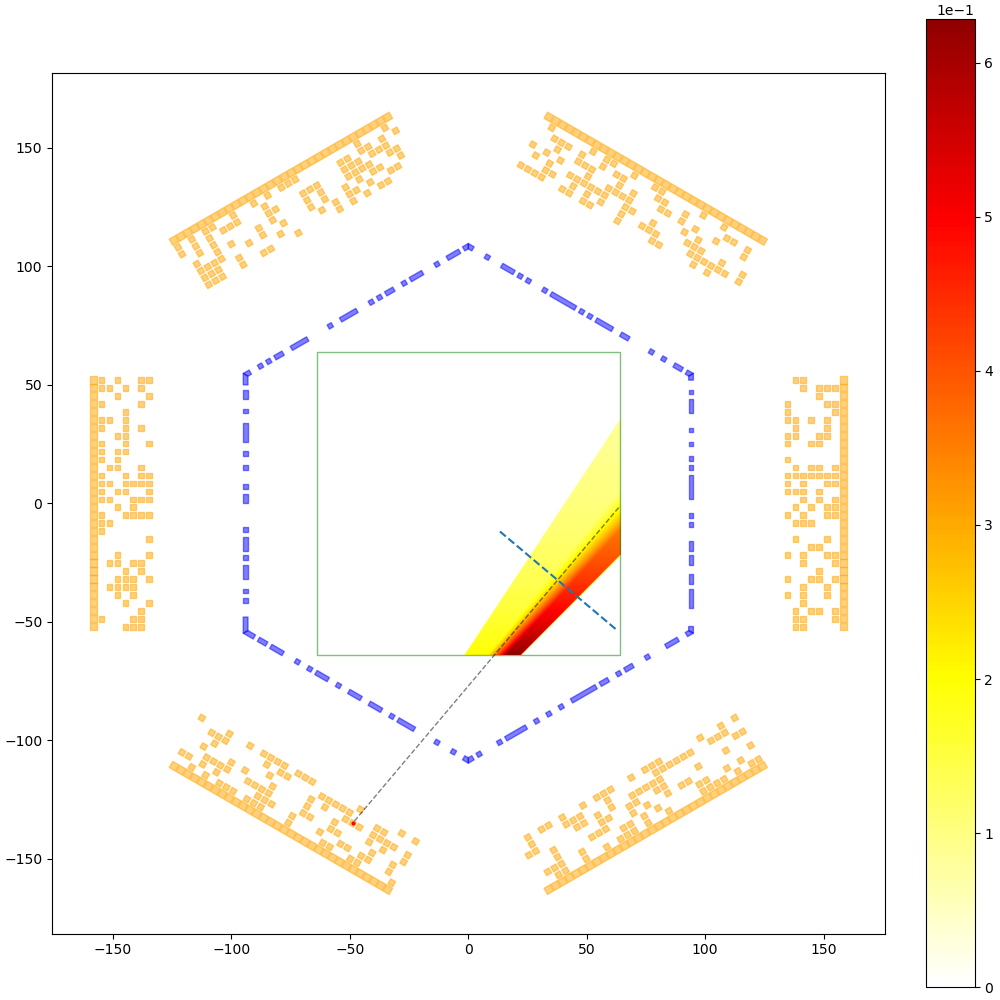

In [23]:
def beam_sampling_line(
    detector_unit_center: torch.Tensor,
    beam_weighted_center: torch.Tensor,
    n_samples: int = 1024,
    length: float = 32.0,
):
    beam_axis_rad = torch.atan2(
        beam_weighted_center[1] - detector_unit_center[1],
        beam_weighted_center[0] - detector_unit_center[0],
    )
    beam_axis_rad = beam_axis_rad + 2 * torch.pi * (beam_axis_rad < 0)
    sampling_line_rad = beam_axis_rad + torch.pi * 0.5
    kx = torch.cos(sampling_line_rad)
    ky = torch.sin(sampling_line_rad)
    sampling_distance = torch.linspace(-length / 2, length / 2, n_samples)
    return (
        torch.stack((sampling_distance * kx, sampling_distance * ky), dim=1)
        + beam_weighted_center
    ), sampling_distance


beam_sampling_point, _ = beam_sampling_line(
    detector_units_centers[crystal_id],
    beams_weighted_centers[beam_id],
    n_samples=128,
    length=64.0,
)
fig, ax = plt.subplots(
    figsize=(10, 10),
    layout="constrained",
)


scanner_mpl_objs = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, ax, fov_dict
)
beam_imshow_obj = plot_new_ppdf_mpl(
    template.view(512, 512),
    ax=ax,
    fov_dict=fov_dict,
)
beam_axis_line = ax.axline(
    xy1=(
        beams_weighted_centers[beam_id, 0].item(),
        beams_weighted_centers[beam_id, 1].item(),
    ),
    xy2=(
        detector_units_centers[crystal_id, 0].item(),
        detector_units_centers[crystal_id, 1].item(),
    ),
    ls="--",
    color="k",
    lw=1,
    alpha=0.5,
)


beam_axis_line.set_clip_path(
    hull_mpl_obj.get_paths()[0], transform=beam_axis_line.axes.transData
)
ax.plot(
    detector_units_centers[crystal_id, 0],
    detector_units_centers[crystal_id, 1],
    "ro",
    markersize=2,
    label="detector unit center",
)
ax.plot(
    beam_sampling_point[[0, -1], 0],
    beam_sampling_point[[0, -1], 1],
    "--C0",
    label="beam sampling points",
)
ax.set_aspect("equal")
ax.autoscale()

In [24]:
def beam_samples_on_line_2d_local(
    beam_data_2d: torch.Tensor,
    detector_center: torch.Tensor,
    beam_center: torch.Tensor,
    fov_dict: dict,
    n_samples: int = 1024,
):
    # Get the sampling points
    beam_sampling_point, sampling_distance = beam_sampling_line(
        detector_center,
        beam_center,
        n_samples=n_samples + 1,
        length=64.0,
    )

    # Prepare the input and grid for sampling

    # 2D PPDF field
    beam_field = beam_data_2d.T.view(
        1, 1, int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
    ).to(torch.float32)

    # The grid contains the coordinates of the points where the input scalar
    # field is sampled. The grid is in the range [-1, 1] for both x and y.

    grid = (
        beam_sampling_point.unsqueeze(0).unsqueeze(0).to(torch.float32)
        / fov_dict["size in mm"]
        * 2
    )
    sampled_beam = nn.functional.grid_sample(
        beam_field, grid, mode="bilinear", align_corners=True
    ).squeeze()
    return (
        sampled_beam,
        beam_sampling_point,
        sampling_distance,
    )

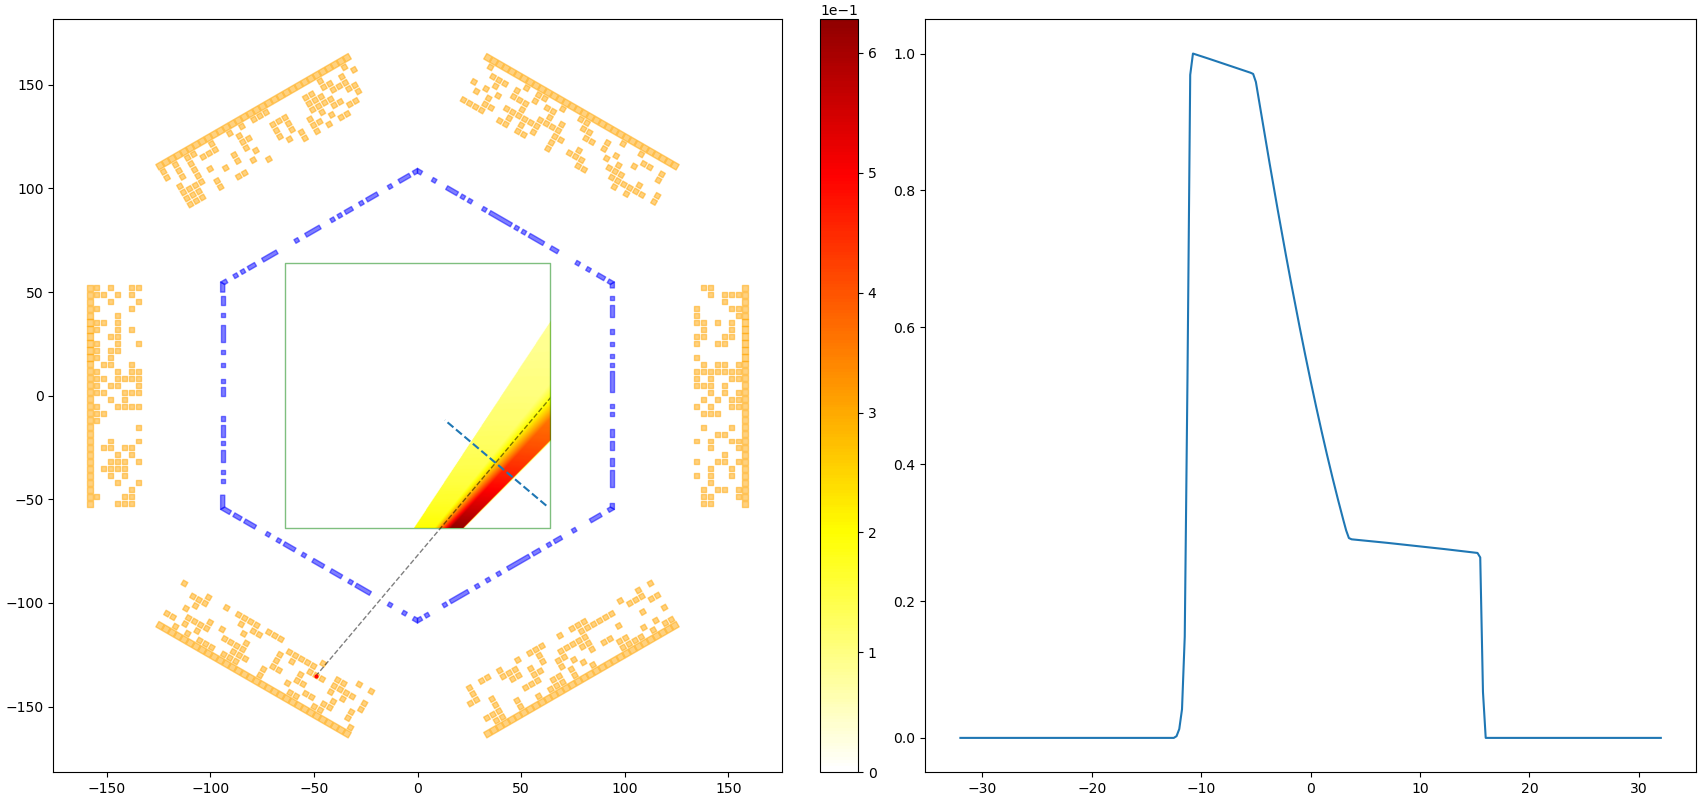

In [25]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(17, 8),
    layout="constrained",
)


scanner_mpl_objs = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, axs[0], fov_dict
)
beam_imshow_obj = plot_new_ppdf_mpl(
    template.view(512, 512),
    ax=axs[0],
    fov_dict=fov_dict,
)
beam_axis_line = axs[0].axline(
    xy1=(
        beams_weighted_centers[beam_id, 0].item(),
        beams_weighted_centers[beam_id, 1].item(),
    ),
    xy2=(
        detector_units_centers[crystal_id, 0].item(),
        detector_units_centers[crystal_id, 1].item(),
    ),
    ls="--",
    color="k",
    lw=1,
    alpha=0.5,
)

sampled_beam, beam_sampling_points, sampling_distance = beam_samples_on_line_2d_local(
    template.view(512, 512),
    detector_units_centers[crystal_id],
    beams_weighted_centers[beam_id],
    fov_dict=fov_dict,
    n_samples=256,
)
beam_axis_line.set_clip_path(
    hull_mpl_obj.get_paths()[0], transform=beam_axis_line.axes.transData
)
axs[0].plot(
    detector_units_centers[crystal_id, 0],
    detector_units_centers[crystal_id, 1],
    "ro",
    markersize=2,
    label="detector unit center",
)
axs[0].plot(
    beam_sampling_points[[0, -1], 0],
    beam_sampling_points[[0, -1], 1],
    "--C0",
    label="beam sampling points",
)
axs[0].set_aspect("equal")
axs[0].autoscale()

axs[1].plot(
    sampling_distance,
    sampled_beam / sampled_beam.max(),
    color="C0",
    label="sampled beam",
)

In [32]:
def full_width_half_max_1d(
    x: torch.Tensor,
    y: torch.Tensor,
):
    # Find the indices of the points where the curve crosses half of the maximum
    half_max = y.max() / 2
    indices = torch.argwhere(y >= half_max).squeeze()
    if indices.shape[0] < 2:
        return None, None
    # Get the first and last indices
    x1 = x[indices[0]]
    x2 = x[indices[-1]]
    fwhm = x2 - x1
    return x1, x2, fwhm

(-36.0, 36.0)

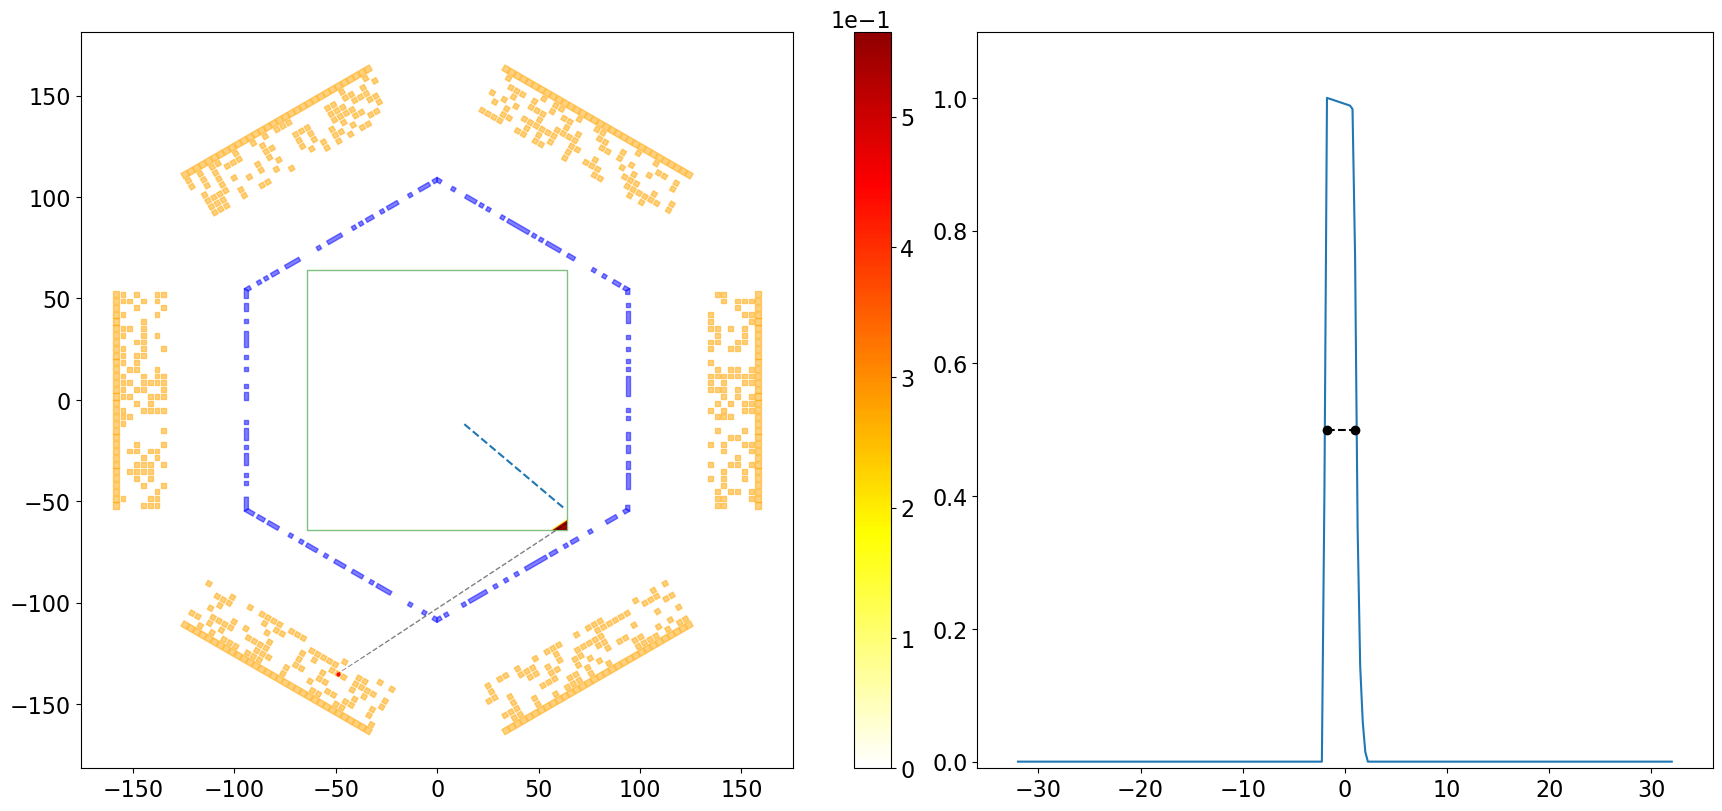

In [33]:
sampled_beam, beam_sampling_points, sampling_distance=beam_samples_on_line_2d_local(
    template.view(512, 512),
    detector_units_centers[crystal_id],
    beams_weighted_centers[beam_id],
    fov_dict=fov_dict,
    n_samples=256,
)
x1,x2,fwhm = full_width_half_max_1d(
    sampling_distance,
    sampled_beam / sampled_beam.max(),
)

%matplotlib inline
fig, axs = plt.subplots(1, 2,
    figsize=(17, 8),
    layout="constrained",
)


scanner_mpl_objs = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, axs[0], fov_dict
)
beam_imshow_obj = plot_new_ppdf_mpl(
    template.view(512, 512),
    ax=axs[0],
    fov_dict=fov_dict,
)
beam_axis_line = axs[0].axline(
    xy1=(
        beams_weighted_centers[beam_id, 0].item(),
        beams_weighted_centers[beam_id, 1].item(),
    ),
    xy2=(
        detector_units_centers[crystal_id, 0].item(),
        detector_units_centers[crystal_id, 1].item(),
    ),
    ls="--",
    color="k",
    lw=1,
    alpha=0.5,
)


beam_axis_line.set_clip_path(
    hull_mpl_obj.get_paths()[0], transform=beam_axis_line.axes.transData
)
axs[0].plot(
    detector_units_centers[crystal_id, 0],
    detector_units_centers[crystal_id, 1],
    "ro",
    markersize=2,
    label="detector unit center",
)
axs[0].plot(
    beam_sampling_point[[0, -1], 0],
    beam_sampling_point[[0, -1], 1],
    "--C0",
    label="beam sampling points",
)
axs[0].set_aspect("equal")
axs[0].autoscale()

axs[1].plot(
    sampling_distance,
    sampled_beam / sampled_beam.max(),
    color="C0",
    label="sampled beam",
)

axs[1].plot(
    [x1, x2],
    [0.5, 0.5],
    "--ko",
    label="FWHM",
)
axs[1].set_ylim(-0.01, 1.1)
axs[1].set_xlim(-36, 36)

In [34]:
beam_nsamples = 256
beams_sampling_points = torch.empty((0, beam_nsamples + 1, 2), dtype=torch.float32)
beams_sampled_data = torch.empty((0, beam_nsamples + 1), dtype=torch.float32)
beams_fwhm_x1x2 = torch.empty((0, 2), dtype=torch.float32)
beams_fwhm = torch.empty((0,), dtype=torch.float32)
for beam_id in range(beams_weighted_centers.shape[0]):
    template = normalized_ppdf.clone()
    template.view(-1)[~beams_masks[beam_id]] = 0
    sampled_beam, beam_sampling_points, sampling_distance = (
        beam_samples_on_line_2d_local(
            template.view(512, 512),
            detector_units_centers[crystal_id],
            beams_weighted_centers[beam_id],
            fov_dict=fov_dict,
            n_samples=beam_nsamples,
        )
    )
    x1, x2, fwhm = full_width_half_max_1d(
        sampling_distance,
        sampled_beam / sampled_beam.max(),
    )
    beams_sampling_points = torch.cat(
        [
            beams_sampling_points,
            beam_sampling_points.view(1, beam_nsamples + 1, 2),
        ],
        dim=0,
    )
    beams_sampled_data = torch.cat(
        [
            beams_sampled_data,
            sampled_beam.view(1, beam_nsamples + 1),
        ],
        dim=0,
    )
    beams_fwhm = torch.cat(
        [
            beams_fwhm,
            fwhm.view(1),
        ],
        dim=0,
    )
    beams_fwhm_x1x2 = torch.cat(
        [
            beams_fwhm_x1x2,
            torch.stack((x1, x2)).view(1, 2),
        ],
        dim=0,
    )
print(beams_fwhm.shape)
print(beams_fwhm_x1x2.shape)
print(beams_sampling_points.shape)

torch.Size([8])
torch.Size([8, 2])
torch.Size([8, 257, 2])


In [35]:
beams_weighted_centers = torch.empty((0, 2), dtype=torch.float32)
beams_masks = torch.empty((0, int(fov_dict["n pixels"].prod())), dtype=bool)
beams_rads_edges = torch.empty((0, 2), dtype=torch.float32)
beams_means = torch.empty((0,), dtype=torch.float32)
beams_maxs = torch.empty((0,), dtype=torch.float32)
print(rads_edges.shape)
for i in range(rads_edges.shape[0] - 1):
    in_range_mask = torch.logical_and(
        pixel_angles >= rads_edges[i],
        pixel_angles <= rads_edges[i + 1],
    )
    
    # print(in_range_mask.shape)
    normalized_ppdf_mean = normalized_ppdf.view(-1)[in_range_mask].mean()
    # Discard the range with mean < 0.01
    if normalized_ppdf_mean < 0.01:
        continue

    weighted_center = (
        normalized_ppdf.view(-1)[in_range_mask].view(-1, 1).expand(-1, 2)
        * pixel_coordinates[in_range_mask]
    ).sum(dim=0) / (normalized_ppdf.view(-1)[in_range_mask].sum() + 1e-8)

    beams_weighted_centers = torch.cat(
        [
            beams_weighted_centers,
            weighted_center.unsqueeze(0),
        ],
        dim=0,
    )
    beams_masks = torch.cat(
        [
            beams_masks,
            in_range_mask.unsqueeze(0),
        ],
        dim=0,
    )
    beams_rads_edges = torch.cat(
        [
            beams_rads_edges,
            rads_edges[i : i + 2].unsqueeze(0),
        ],
        dim=0,
    )
    print(
        f"Angle range: {float(rads_edges[i].item()/torch.pi*180):03.2f} - {rads_edges[i + 1].item()/torch.pi*180:03.2f} degrees",
        f"PPDF mean: {normalized_ppdf_mean.item():.4f}",
        f"weighted center: {weighted_center}",
        f"number of pixels: {in_range_mask.sum().item()}",
    )

torch.Size([16])
Angle range: 32.05 - 34.25 degrees PPDF mean: 0.3985 weighted center: tensor([ 61.3903, -62.4780]) number of pixels: 402
Angle range: 36.15 - 42.64 degrees PPDF mean: 0.4693 weighted center: tensor([ 50.0982, -52.4931]) number of pixels: 7974
Angle range: 44.72 - 56.56 degrees PPDF mean: 0.2194 weighted center: tensor([ 37.6729, -32.3958]) number of pixels: 39196
Angle range: 66.19 - 68.63 degrees PPDF mean: 0.1076 weighted center: tensor([ 7.1370, -0.1112]) number of pixels: 13797
Angle range: 70.88 - 75.62 degrees PPDF mean: 0.3713 weighted center: tensor([-8.4984, -0.1223]) number of pixels: 24956
Angle range: 81.93 - 86.19 degrees PPDF mean: 0.4085 weighted center: tensor([-34.9286,  -0.1234]) number of pixels: 20795
Angle range: 91.63 - 95.06 degrees PPDF mean: 0.2140 weighted center: tensor([-56.7009,  -0.3749]) number of pixels: 16091
Angle range: 96.70 - 99.59 degrees PPDF mean: 0.2155 weighted center: tensor([-61.5101, -45.0473]) number of pixels: 2763


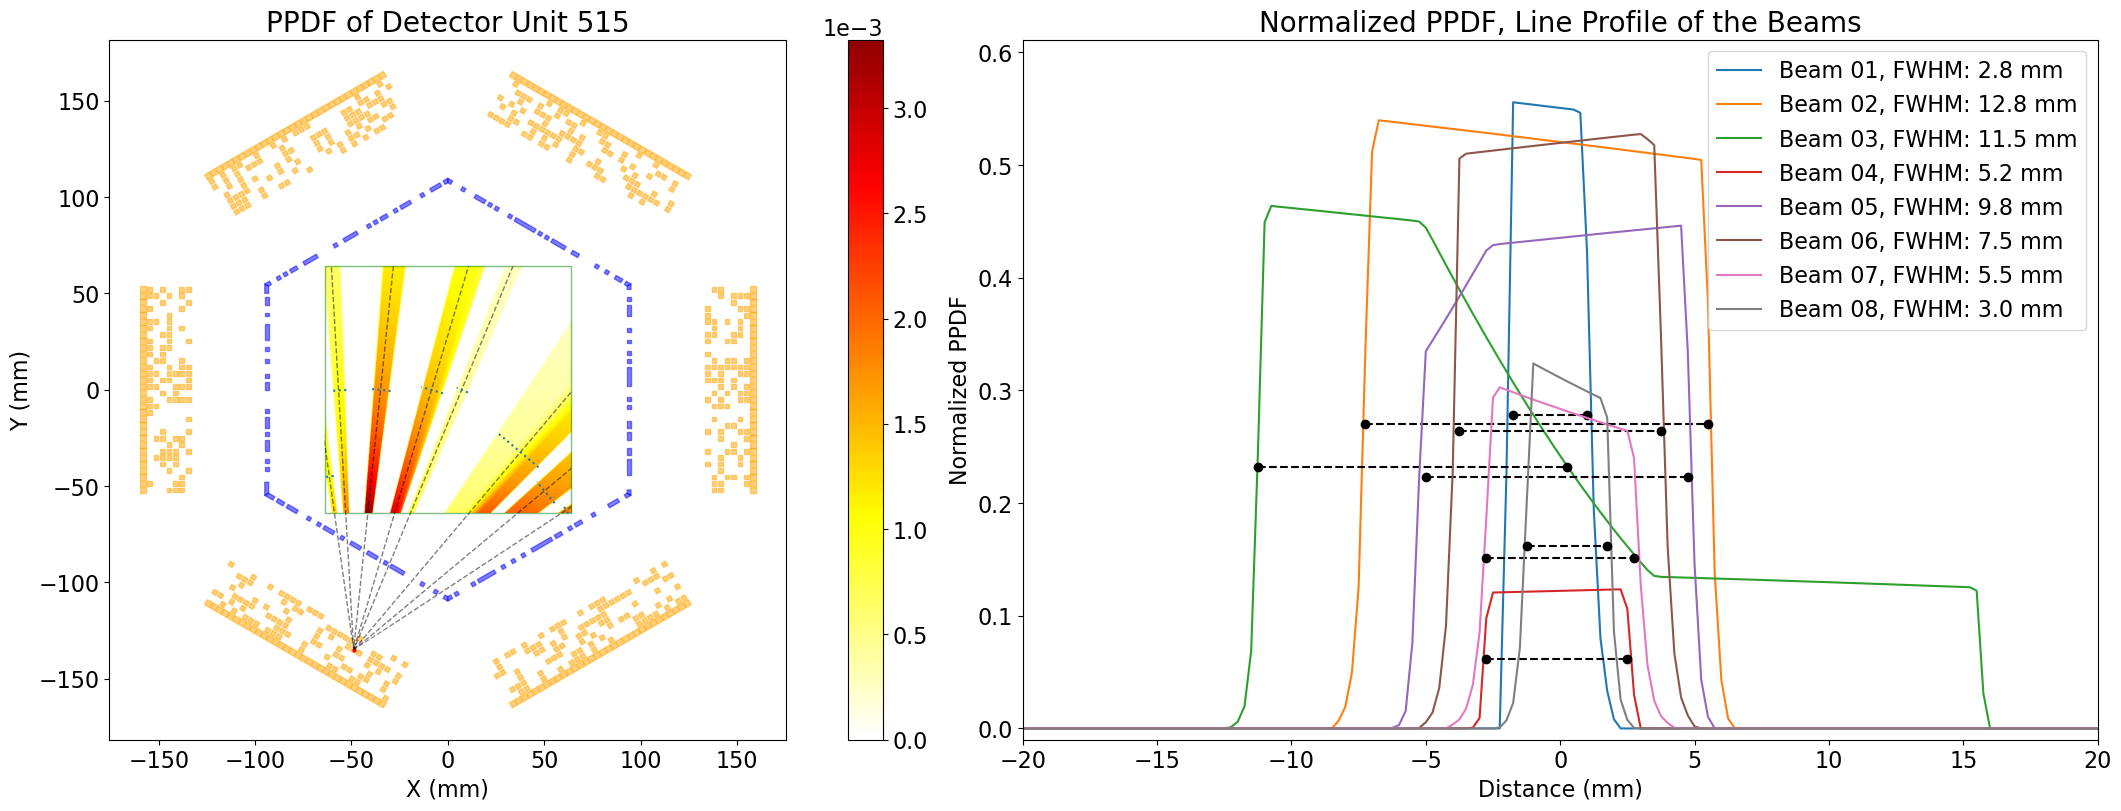

In [36]:
%matplotlib inline
plt.rcParams["font.size"] = 16
fig, axs = plt.subplots(1, 2,
    figsize=(21, 8),
    layout="constrained",
    gridspec_kw={"width_ratios": [1, 1.5]},
)


scanner_mpl_objs = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, axs[0], fov_dict
)
beam_imshow_obj = plot_new_ppdf_mpl(
    ppdfs[crystal_id,0],
    ax=axs[0],
    fov_dict=fov_dict,
)
axs[0].plot(
    detector_units_centers[crystal_id, 0],
    detector_units_centers[crystal_id, 1],
    "ro",
    markersize=2,
    label="detector unit center",
)
axs[0].set_aspect("equal")

beam_sampling_line_x = torch.linspace(
    -32,32,
    beam_nsamples+1,
)
for beam_id in range(beams_weighted_centers.shape[0]):
    beam_axis_line = axs[0].axline(
        xy1=(
            beams_weighted_centers[beam_id, 0].item(),
            beams_weighted_centers[beam_id, 1].item(),
        ),
        xy2=(
            detector_units_centers[crystal_id, 0].item(),
            detector_units_centers[crystal_id, 1].item(),
        ),
        ls="--",
        color="k",
        lw=1,
        alpha=0.5,
    )


    beam_axis_line.set_clip_path(
        hull_mpl_obj.get_paths()[0], transform=beam_axis_line.axes.transData
    )
    axs[1].plot(
        beam_sampling_line_x,
        beams_sampled_data[beam_id],
        # color="C0",
        label=f"Beam {beam_id+1:02d}, FWHM: {beams_fwhm[beam_id].item():2.1f} mm",
    )

    axs[1].plot(
        beams_fwhm_x1x2[beam_id, 0:2],
        torch.tensor([0.5, 0.5])*beams_sampled_data[beam_id].max(),
        "--ko",
    )
    above_tiny = beams_sampled_data[beam_id] > 0.0
    plotting_points = beams_sampling_points[beam_id, above_tiny]
    axs[0].plot(
        plotting_points[[0,-1], 0],
        plotting_points[[0,-1], 1],
        ":C0",
        label="beam sampling points",
    )
# axs[0].plot(
#     beam_sampling_point[[0, -1], 0],
#     beam_sampling_point[[0, -1], 1],
#     "--C0",
#     label="beam sampling points",
# )
axs[0].autoscale()
axs[0].set_title(f"PPDF of Detector Unit {crystal_id:03d}", fontsize=20)
axs[0].set_xlabel("X (mm)")
axs[0].set_ylabel("Y (mm)")
axs[1].set_ylim(-0.01, beams_sampled_data.max()*1.1)
axs[1].set_xlim(-20, 20)
axs[1].set_title(f"Normalized PPDF, Line Profile of the Beams", fontsize=20)
axs[1].set_xlabel("Distance (mm)")
axs[1].set_ylabel("Normalized PPDF")
axs[1].legend(
    loc="upper right",
    fontsize=16,

)
out_filename = f"beam_analysis_detector_unit_{crystal_id:03d}.png"
fig.savefig(os.path.join("output", out_filename), dpi=300)